In [46]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from pandas.core import datetools
from pandas import Series, DataFrame

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

from arch import arch_model

from scipy.stats import spearmanr,ttest_ind
from sklearn.preprocessing import MinMaxScaler


In [47]:
data=pd.read_csv('all.csv')

In [48]:
data.head()

,Date,Adj_Close,Volume,Oil_price,Adj_Close_SP
0,2009-05-01,31.726078,5508800,53.20,877.520020
1,2009-05-04,32.472832,5269800,54.47,907.239990
2,2009-05-05,33.219616,7683900,53.84,903.799988
3,2009-05-06,34.362438,7930300,56.34,919.530029
4,2009-05-07,33.841553,7106700,56.71,907.390015


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 5 columns):
Date            2515 non-null object
Adj_Close       2515 non-null float64
Volume          2515 non-null int64
Oil_price       2515 non-null float64
Adj_Close_SP    2515 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 98.3+ KB


In [50]:
data['Date']=pd.to_datetime(data["Date"])

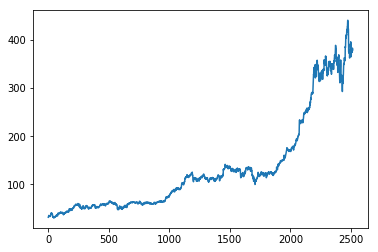

In [51]:
data["Adj_Close"].plot()
plt.show()

In [52]:
data=data.set_index(data.Date)
data=data.drop("Date",axis=1)

In [53]:
result = adfuller(data.Adj_Close,regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
# we have not enough evidence to reject the non-stationarity hypothesis, so the data is not stationary.

ADF Statistic: -1.131747
p-value: 0.923579
Critical Values:
	1%: -3.962
	5%: -3.412
	10%: -3.128


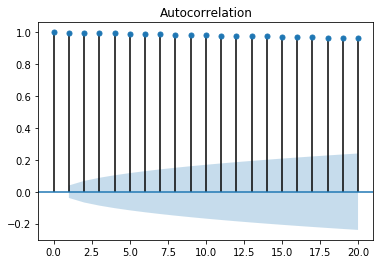

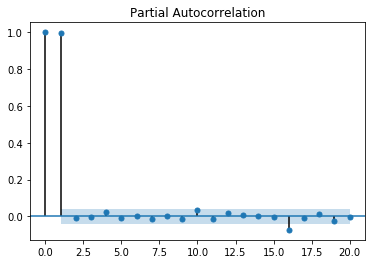

In [54]:
plot_acf(data.Adj_Close,lags=20)
plot_pacf(data.Adj_Close,lags=20)
plt.show()

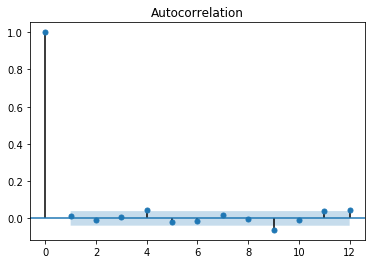

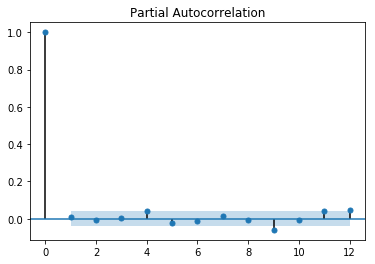

In [55]:
diff = data.Adj_Close.diff(periods=1)
diff.dropna(inplace=True)
plot_acf(diff,lags=12)
plot_pacf(diff,lags=12)
plt.show()

In [56]:
result = adfuller(diff,regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -9.097369
p-value: 0.000000
Critical Values:
	1%: -3.962
	5%: -3.412
	10%: -3.128


In [57]:
result = adfuller(data.Oil_price,regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.517871
p-value: 0.319086
Critical Values:
	1%: -3.962
	5%: -3.412
	10%: -3.128


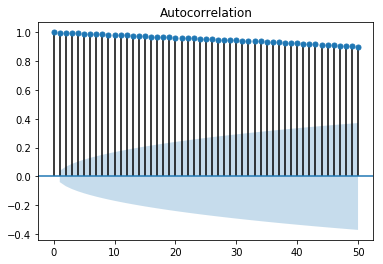

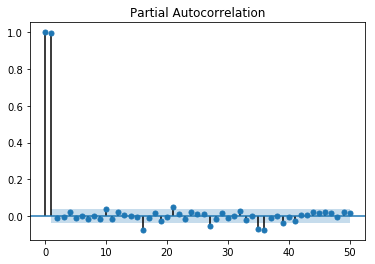

In [58]:
plot_acf(data.Adj_Close,lags=50)
plot_pacf(data.Adj_Close,lags=50)
plt.show()

# Arima for first air crash - 10/29/2018

In [59]:
start_date = '2013-10-28'
end_date ='2018-10-28'
test_start='2018-10-29'
test_end='2019-03-10'

In [60]:
#train=data[(data.Date>=start_date) & (data.Date<=end_date) ]
train=data[start_date:end_date]
train=train['Adj_Close']
train.tail()

Date
2018-10-22    352.572510
2018-10-23    346.699219
2018-10-24    351.255188
2018-10-25    360.287872
2018-10-26    355.830963
Name: Adj_Close, dtype: float64

In [61]:
#test=data[(data.Date>=test_start) & (data.Date<=test_end) ]
test=data[test_start:test_end]
test=test["Adj_Close"]
test.head()

Date
2018-10-29    332.377655
2018-10-30    346.560577
2018-10-31    351.463165
2018-11-01    359.594635
2018-11-02    354.325531
Name: Adj_Close, dtype: float64

In [62]:
print(len(train))
print(len(test))
print(len(test)*100/(len(train)+len(test)))

1260
89
6.597479614529281


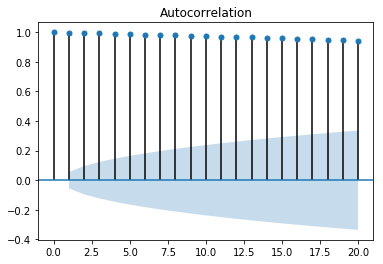

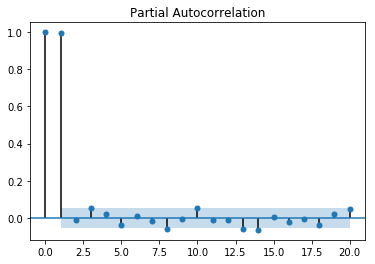

In [63]:
plot_acf(train,lags=20)
plot_pacf(train,lags=20)
plt.show()

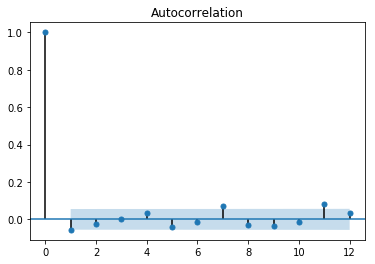

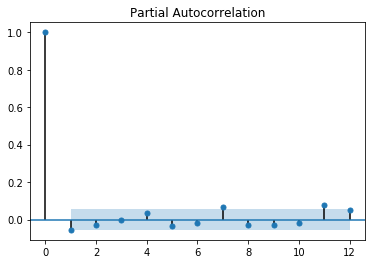

In [64]:
diff = train.diff(periods=1)
diff.dropna(inplace=True)
plot_acf(diff,lags=12)
plot_pacf(diff,lags=12)
plt.show()

In [65]:
result = adfuller(diff,regression='ct', autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.155224
p-value: 0.000000
Critical Values:
	1%: -3.966
	5%: -3.414
	10%: -3.129


in the pacf plots the negative correlation for lag 1 shows that we do not need an AR term but we do need an MA term. the higher standard deviation for the difference compared to otiginal series shows that no differencing is needed. so I think we should use (0,0,1) for the model, but let's try some combinations and compare.

In [66]:
stepwise_fit = auto_arima(train, start_p=1, start_q=1, max_p=10, max_q=10,
                          start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=6312.824, BIC=6333.377, Fit time=0.211 seconds
Fit ARIMA: order=(0, 1, 0); AIC=6313.473, BIC=6323.749, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=6311.631, BIC=6327.045, Fit time=0.024 seconds
Fit ARIMA: order=(0, 1, 1); AIC=6311.398, BIC=6326.813, Fit time=0.016 seconds
Fit ARIMA: order=(0, 1, 2); AIC=6312.557, BIC=6333.109, Fit time=0.056 seconds


C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array i

Fit ARIMA: order=(1, 1, 2); AIC=6314.548, BIC=6340.238, Fit time=0.288 seconds
Total fit time: 0.607 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1259
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3152.699
Method:                       css-mle   S.D. of innovations              2.960
Date:                Tue, 07 May 2019   AIC                           6311.398
Time:                        19:35:45   BIC                           6326.813
Sample:                             1   HQIC                          6317.191
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1936      0.079      2.465      0.014       0.040       0.348
ma.L1.D.y     -0.0585      0.029     -2.025      0.043      -0.115      -0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           17.0850           +0.0000j           17.0850            0.0000
-----------------------------------------------------------------------------
"""

C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


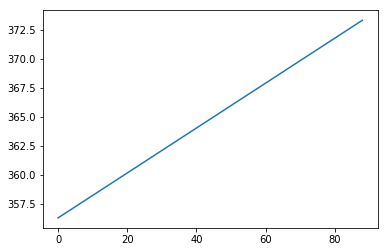

In [67]:
plt.plot(stepwise_fit.predict(n_periods=89))

C:\Users\Acer\Anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Acer\Anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj_Close   No. Observations:                 1259
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3152.699
Method:                       css-mle   S.D. of innovations              2.960
Date:                Tue, 07 May 2019   AIC                           6311.398
Time:                        19:35:45   BIC                           6326.813
Sample:                             1   HQIC                          6317.191
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1936      0.079      2.465      0.014       0.040       0.348
ma.L1.D.Adj_Close    -0.0585      0.029     -2.025      0.043      -0.115      -0.002
                        

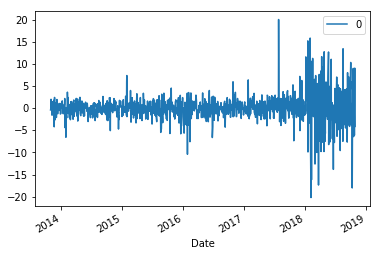

                 0
count  1259.000000
mean     -0.000019
std       2.961178
min     -20.198709
25%      -1.222651
50%      -0.022711
75%       1.095450
max      20.063453


In [68]:
# fit model
model = ARIMA(train, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

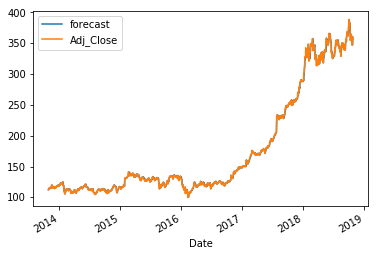

In [69]:
model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


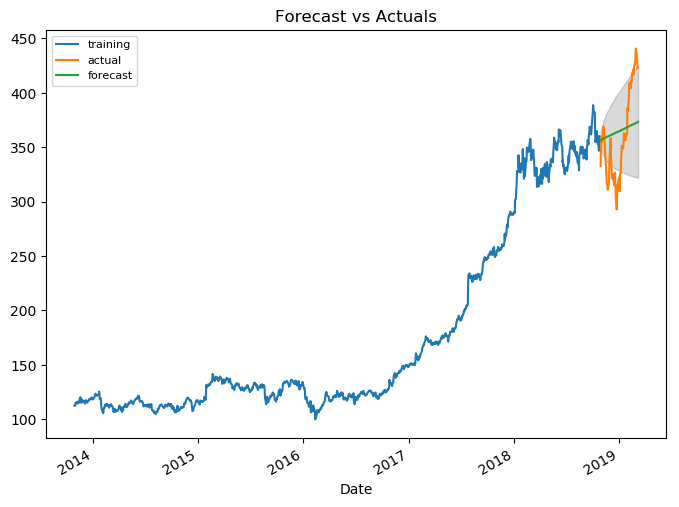

In [70]:
# Forecast
fc, se, conf = model_fit.forecast(len(test),alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,6), dpi=100)
train.plot(label='training')
test.plot(label='actual')
fc_series.plot(label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# ARIMAX

In [71]:
#train=data[(data.Date>=start_date) & (data.Date<=end_date) ]
train=data[start_date:end_date]
train.tail()

,Adj_Close,Volume,Oil_price,Adj_Close_SP
Date,,,,
2018-10-22,352.572510,2263500,69.322,2755.879883
2018-10-23,346.699219,4389600,66.430,2740.689941
2018-10-24,351.255188,8442600,66.820,2656.100098
2018-10-25,360.287872,4003500,67.330,2705.570068
2018-10-26,355.830963,4073000,67.590,2658.689941


In [72]:
#test=data[(data.Date>=test_start) & (data.Date<=test_end) ]
test=data[test_start:test_end]
#test=test["Adj_Close"]
test.head()

,Adj_Close,Volume,Oil_price,Adj_Close_SP
Date,,,,
2018-10-29,332.377655,7462000,67.04,2641.250000
2018-10-30,346.560577,5774000,66.18,2682.629883
2018-10-31,351.463165,4175600,65.31,2711.739990
2018-11-01,359.594635,3760700,63.69,2740.370117
2018-11-02,354.325531,4029800,63.14,2723.060059


In [73]:
stepwise_fit = auto_arima(train.Adj_Close,exogenous=train[["Oil_price","Adj_Close_SP"]],start_p=1, start_q=1,
                          max_p=10, max_q=10,start_P=0, seasonal=False, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=6308.226, BIC=6339.055, Fit time=0.479 seconds
Fit ARIMA: order=(0, 1, 0); AIC=6309.761, BIC=6330.314, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0); AIC=6307.350, BIC=6333.040, Fit time=0.144 seconds


C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array i

Fit ARIMA: order=(0, 1, 1); AIC=6307.046, BIC=6332.736, Fit time=0.147 seconds
Fit ARIMA: order=(0, 1, 2); AIC=6307.945, BIC=6338.773, Fit time=0.256 seconds
Fit ARIMA: order=(1, 1, 2); AIC=6310.665, BIC=6346.631, Fit time=0.338 seconds
Total fit time: 1.661 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1259
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3148.523
Method:                       css-mle   S.D. of innovations              2.950
Date:                Tue, 07 May 2019   AIC                           6307.046
Time:                        19:35:48   BIC                           6332.736
Sample:                             1   HQIC                          6316.700
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4430      0.665     -2.171      0.030      -2.745      -0.141
x1             0.0004      0.004      0.097      0.922      -0.007       0.008
x2             0.0007      0.000      2.850      0.004       0.000       0.001
ma.L1.D.y     -0.0633      0.029     -2.181      0.029      -0.120      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           15.7932           +0.0000j           15.7932            0.0000
-----------------------------------------------------------------------------
"""

C:\Users\Acer\Anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Acer\Anaconda2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Adj_Close   No. Observations:                 1259
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3148.523
Method:                       css-mle   S.D. of innovations              2.950
Date:                Tue, 07 May 2019   AIC                           6307.046
Time:                        19:35:48   BIC                           6332.736
Sample:                             1   HQIC                          6316.700
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4430      0.665     -2.171      0.030      -2.745      -0.141
Oil_price             0.0004      0.004      0.097      0.922      -0.007       0.008
Adj_Close_SP          0.

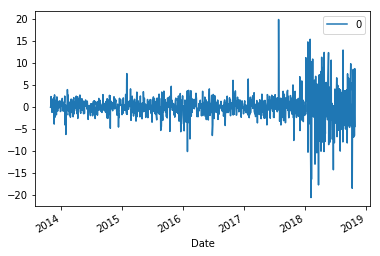

                 0
count  1259.000000
mean     -0.000003
std       2.951370
min     -20.568709
25%      -1.134120
50%       0.034035
75%       1.151227
max      19.874494


In [74]:
# fit model
model = ARIMA(train.Adj_Close,exog=train[["Oil_price","Adj_Close_SP"]], order=(0,1,1))
model_fit = model.fit(trend='c')
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
print(residuals.describe())

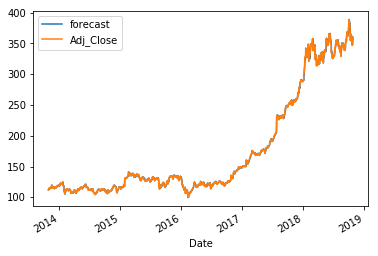

In [75]:
model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\Acer\Anaconda2\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


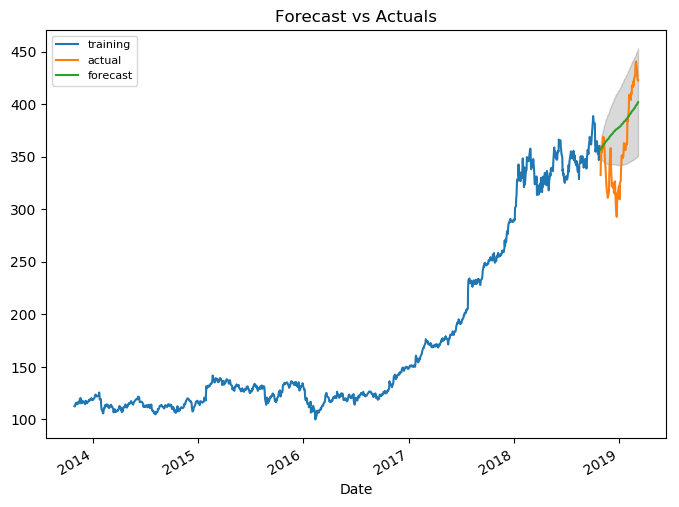

In [76]:
# Forecast
fc, se, conf = model_fit.forecast(len(test),exog=test[["Oil_price","Adj_Close_SP"]],alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,6), dpi=100)
train.Adj_Close.plot(label='training')
test.Adj_Close.plot(label='actual')
fc_series.plot(label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [77]:
forecast_accuracy(fc, test.Adj_Close)

{'mape': 0.09278704975548872,
 'me': 18.208885068301306,
 'mae': 31.742398185262722,
 'mpe': 0.06057522079776788,
 'rmse': 37.017306198267676,
 'corr': 0.7399940257587887,
 'minmax': 0.08284066615785712}